# Baseline Retrieval Teljesítmény Kiértékelése

Ez a notebook a hybrid search (BM25 + FAISS + RRF fusion) baseline teljesítményét értékeli ki.

**Célok:**
- Qrels alapú kiértékelés (nDCG@10, MAP, Recall@K, MRR)
- Baseline score meghatározása GRPO összehasonlításhoz
- Részletes analitika query-szinten és aggregált szinten
- Eredmények mentése későbbi felhasználásra

**Fusion módszer:** RRF (Reciprocal Rank Fusion) - robusztus, skála-független


In [1]:
import json
import sys
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Set, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project root setup
project_root = Path("/workspace") if Path("/workspace").exists() else Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from configs import config
from src.search.hybrid_search import HybridRetriever

print(f"📂 Project root: {project_root}")
print(f"✅ Importok betöltve")


📂 Project root: /Users/zelenyianszkimate/Documents/CourtRankRL
✅ Importok betöltve


## 1. Qrels Betöltése

A relevancia判定 (qrels) fájl betöltése, amely a ground truth annotációkat tartalmazza.


In [2]:
def load_qrels(qrels_path: Path) -> Dict[str, Dict[str, int]]:
    """
    Qrels betöltése TSV formátumból.
    
    Formátum: query_id\tdoc_id\trelevance
    
    Returns:
        Dict[query_id, Dict[doc_id, relevance_grade]]
    """
    qrels = defaultdict(dict)
    
    with open(qrels_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # Skip header
    for line in lines[1:]:
        line = line.strip()
        if not line:
            continue
        parts = line.split('\t')
        if len(parts) != 3:
            continue
        query_id, doc_id, relevance = parts
        qrels[query_id][doc_id] = int(relevance)
    
    return dict(qrels)

# Qrels betöltése
qrels_path = project_root / "data" / "qrels" / "baseline_qrels.tsv"

if not qrels_path.exists():
    print(f"❌ Qrels fájl nem található: {qrels_path}")
    print("⚠️  Hozz létre egy qrels fájlt a kiértékeléshez!")
    qrels = {}
else:
    qrels = load_qrels(qrels_path)
    print(f"✅ Qrels betöltve: {len(qrels)} query, {sum(len(docs) for docs in qrels.values())} relevancia判定")
    
    # Statisztikák
    relevance_counts = defaultdict(int)
    for query_rels in qrels.values():
        for rel_grade in query_rels.values():
            relevance_counts[rel_grade] += 1
    
    print("\n📊 Relevancia eloszlás:")
    for grade in sorted(relevance_counts.keys()):
        print(f"  Grade {grade}: {relevance_counts[grade]} dokumentum")


✅ Qrels betöltve: 98 query, 1950 relevancia判定

📊 Relevancia eloszlás:
  Grade 0: 1950 dokumentum


## 2. Hybrid Retriever Inicializálása


In [3]:
print("🔧 Hybrid Retriever inicializálása...")
retriever = HybridRetriever()
print("✅ Retriever kész")


🔧 Hybrid Retriever inicializálása...
🔧 Modell betöltése (mps) – google/embeddinggemma-300m
✅ EmbeddingGemma modell betöltve
✅ BM25S modell betöltve
✅ BM25 index betöltve (2964527 dokumentum)
ℹ️  FAISS index készenléten (lazy loading)
🔗 Chunk ID mapping betöltve (2964527 elem)
📋 Chunk metadata készenléten (lazy loading): /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/chunks.jsonl
✅ Retriever kész


## 3. Baseline Találati Listák Generálása


In [4]:
def generate_baseline_results(
    retriever: HybridRetriever,
    queries: List[str],
    top_k: int = 10,
    fusion_method: str = "rrf"
) -> Dict[str, List[str]]:
    """
    Baseline találati listák generálása minden query-re.
    
    Returns:
        Dict[query_id, List[doc_id]] rangsorrolt találati listák
    """
    results = {}
    
    for i, query in enumerate(queries, 1):
        print(f"\r⏳ Query feldolgozás: {i}/{len(queries)}", end="")
        try:
            doc_ids = retriever.retrieve(
                query=query,
                top_k=top_k,
                fusion_method=fusion_method
            )
            results[query] = doc_ids
        except Exception as e:
            print(f"\n⚠️  Hiba query feldolgozáskor: {query[:50]}... - {e}")
            results[query] = []
    
    print("\n✅ Baseline eredmények generálva")
    return results

# Generálás
if qrels:
    queries = list(qrels.keys())
    print(f"\n🔍 {len(queries)} query feldolgozása...")
    
    baseline_results = generate_baseline_results(
        retriever=retriever,
        queries=queries,
        top_k=config.TOP_K_RERANKED,
        fusion_method="rrf"
    )
else:
    baseline_results = {}
    print("⚠️  Nincs elérhető query")



🔍 98 query feldolgozása...
⏳ Query feldolgozás: 1/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

🔄 FAISS index betöltése...
ℹ️  FAISS CPU/MPS módban fut
✅ FAISS index betöltve (2964527 vektor)
⏳ Query feldolgozás: 2/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 3/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 4/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 5/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 6/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 7/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 8/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 9/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 10/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 11/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 12/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 13/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 14/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 15/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 16/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 17/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 18/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 19/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 20/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 21/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 22/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 23/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 24/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 25/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 26/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 27/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 28/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 29/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 30/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 31/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 32/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 33/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 34/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 35/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 36/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 37/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 38/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 39/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 40/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 41/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 42/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 43/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 44/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 45/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 46/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 47/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 48/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 49/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 50/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 51/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 52/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 53/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 54/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 55/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 56/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 57/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 58/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 59/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 60/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 61/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 62/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 63/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 64/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 65/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 66/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 67/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 68/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 69/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 70/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 71/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 72/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 73/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 74/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 75/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 76/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 77/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 78/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 79/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 80/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 81/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 82/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 83/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 84/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 85/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 86/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 87/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 88/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 89/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 90/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 91/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 92/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 93/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 94/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 95/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 96/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 97/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Query feldolgozás: 98/98

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Baseline eredmények generálva


## 4. Értékelési Metrikák Implementációja


In [5]:
def dcg_at_k(relevances: List[int], k: int) -> float:
    """Discounted Cumulative Gain@K számítása."""
    relevances = relevances[:k]
    if not relevances:
        return 0.0
    return float(np.sum([rel / np.log2(i + 2) for i, rel in enumerate(relevances)]))

def ndcg_at_k(relevances: List[int], k: int) -> float:
    """Normalized Discounted Cumulative Gain@K számítása."""
    dcg = dcg_at_k(relevances, k)
    ideal_relevances = sorted(relevances, reverse=True)
    idcg = dcg_at_k(ideal_relevances, k)
    if idcg == 0.0:
        return 0.0
    return dcg / idcg

def precision_at_k(relevances: List[int], k: int) -> float:
    """Precision@K számítása."""
    relevances = relevances[:k]
    if not relevances:
        return 0.0
    return float(np.mean([1 if rel > 0 else 0 for rel in relevances]))

def recall_at_k(relevances: List[int], total_relevant: int, k: int) -> float:
    """Recall@K számítása."""
    if total_relevant == 0:
        return 0.0
    relevances = relevances[:k]
    relevant_retrieved = sum(1 for rel in relevances if rel > 0)
    return float(relevant_retrieved / total_relevant)

def average_precision(relevances: List[int]) -> float:
    """Average Precision számítása egy query-re."""
    if not relevances:
        return 0.0
    
    total_relevant = sum(1 for rel in relevances if rel > 0)
    if total_relevant == 0:
        return 0.0
    
    precisions = []
    relevant_count = 0
    
    for i, rel in enumerate(relevances, 1):
        if rel > 0:
            relevant_count += 1
            precisions.append(relevant_count / i)
    
    return float(np.mean(precisions)) if precisions else 0.0

def reciprocal_rank(relevances: List[int]) -> float:
    """Reciprocal Rank számítása (első releváns dokumentum pozíciója)."""
    for i, rel in enumerate(relevances, 1):
        if rel > 0:
            return 1.0 / i
    return 0.0

print("✅ Metrika függvények definiálva")


✅ Metrika függvények definiálva


## 5. Baseline Teljesítmény Kiértékelése


In [6]:
def evaluate_results(
    results: Dict[str, List[str]],
    qrels: Dict[str, Dict[str, int]],
    k_values: List[int] = [5, 10, 20]
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """
    Találati listák kiértékelése qrels alapján.
    
    Returns:
        - Query-szintű metrikák DataFrame
        - Aggregált metrikák Dictionary
    """
    query_metrics = []
    
    for query_id, retrieved_docs in results.items():
        if query_id not in qrels:
            continue
        
        query_qrels = qrels[query_id]
        total_relevant = sum(1 for rel in query_qrels.values() if rel > 0)
        
        # Relevancia értékek a visszaadott sorrendben
        relevances = [query_qrels.get(doc_id, 0) for doc_id in retrieved_docs]
        
        # Metrikák számítása
        metrics = {
            "query_id": query_id,
            "total_relevant": total_relevant,
            "retrieved": len(retrieved_docs),
        }
        
        for k in k_values:
            metrics[f"ndcg@{k}"] = ndcg_at_k(relevances, k)
            metrics[f"precision@{k}"] = precision_at_k(relevances, k)
            metrics[f"recall@{k}"] = recall_at_k(relevances, total_relevant, k)
        
        metrics["map"] = average_precision(relevances)
        metrics["mrr"] = reciprocal_rank(relevances)
        
        query_metrics.append(metrics)
    
    # DataFrame készítése
    df = pd.DataFrame(query_metrics)
    
    # Aggregált metrikák
    aggregated = {}
    for col in df.columns:
        if col not in ["query_id", "total_relevant", "retrieved"]:
            aggregated[col] = float(df[col].mean())
    
    aggregated["num_queries"] = len(df)
    aggregated["total_relevant_docs"] = int(df["total_relevant"].sum())
    
    return df, aggregated

# Kiértékelés
if baseline_results and qrels:
    print("\n📊 Baseline kiértékelése...")
    query_metrics_df, aggregated_metrics = evaluate_results(
        results=baseline_results,
        qrels=qrels,
        k_values=[5, 10, 20]
    )
    
    print("\n✅ Kiértékelés kész")
    print(f"   {aggregated_metrics['num_queries']} query értékelve")
else:
    print("⚠️  Nincs adat a kiértékeléshez")
    query_metrics_df = pd.DataFrame()
    aggregated_metrics = {}



📊 Baseline kiértékelése...

✅ Kiértékelés kész
   98 query értékelve


## 6. Aggregált Eredmények Megjelenítése


In [7]:
if aggregated_metrics:
    print("\n" + "="*60)
    print("🎯 BASELINE TELJESÍTMÉNY (Aggregált Metrikák)")
    print("="*60)
    
    print(f"\n📈 Általános statisztikák:")
    print(f"  • Értékelt query-k száma: {aggregated_metrics['num_queries']}")
    print(f"  • Összes releváns dokumentum: {aggregated_metrics['total_relevant_docs']}")
    
    print(f"\n🎯 Főbb metrikák:")
    print(f"  • nDCG@10:     {aggregated_metrics.get('ndcg@10', 0.0):.4f}")
    print(f"  • MAP:         {aggregated_metrics.get('map', 0.0):.4f}")
    print(f"  • MRR:         {aggregated_metrics.get('mrr', 0.0):.4f}")
    
    print(f"\n📊 nDCG különböző K értékeken:")
    for k in [5, 10, 20]:
        key = f"ndcg@{k}"
        if key in aggregated_metrics:
            print(f"  • nDCG@{k}:  {aggregated_metrics[key]:.4f}")
    
    print(f"\n🎯 Precision különböző K értékeken:")
    for k in [5, 10, 20]:
        key = f"precision@{k}"
        if key in aggregated_metrics:
            print(f"  • P@{k}:     {aggregated_metrics[key]:.4f}")
    
    print(f"\n📈 Recall különböző K értékeken:")
    for k in [5, 10, 20]:
        key = f"recall@{k}"
        if key in aggregated_metrics:
            print(f"  • R@{k}:     {aggregated_metrics[key]:.4f}")
    
    print("\n" + "="*60)



🎯 BASELINE TELJESÍTMÉNY (Aggregált Metrikák)

📈 Általános statisztikák:
  • Értékelt query-k száma: 98
  • Összes releváns dokumentum: 0

🎯 Főbb metrikák:
  • nDCG@10:     0.0000
  • MAP:         0.0000
  • MRR:         0.0000

📊 nDCG különböző K értékeken:
  • nDCG@5:  0.0000
  • nDCG@10:  0.0000
  • nDCG@20:  0.0000

🎯 Precision különböző K értékeken:
  • P@5:     0.0000
  • P@10:     0.0000
  • P@20:     0.0000

📈 Recall különböző K értékeken:
  • R@5:     0.0000
  • R@10:     0.0000
  • R@20:     0.0000



## 7. Query-szintű Eredmények


In [8]:
if not query_metrics_df.empty:
    print("\n📋 Top 10 legjobb teljesítményű query (nDCG@10 alapján):")
    display(query_metrics_df.nlargest(10, "ndcg@10")[["query_id", "ndcg@10", "map", "mrr", "precision@10", "recall@10"]])
    
    print("\n📋 Top 10 leggyengébb teljesítményű query (nDCG@10 alapján):")
    display(query_metrics_df.nsmallest(10, "ndcg@10")[["query_id", "ndcg@10", "map", "mrr", "precision@10", "recall@10"]])



📋 Top 10 legjobb teljesítményű query (nDCG@10 alapján):


,query_id,ndcg@10,map,mrr,precision@10,recall@10
0,adásvételi szerződés módosítása,0.0,0.0,0.0,0.0,0.0
1,adásvételi szerződés érvénytelensége,0.0,0.0,0.0,0.0,0.0
2,adóhatósági végrehajtás,0.0,0.0,0.0,0.0,0.0
3,adóköteles tevékenység,0.0,0.0,0.0,0.0,0.0
4,adótartozás behajtás,0.0,0.0,0.0,0.0,0.0
5,albérlet engedélyezése,0.0,0.0,0.0,0.0,0.0
6,becsületsértés,0.0,0.0,0.0,0.0,0.0
7,birtokvédelem,0.0,0.0,0.0,0.0,0.0
8,biztosítási csalás,0.0,0.0,0.0,0.0,0.0
9,biztosítási szerződés,0.0,0.0,0.0,0.0,0.0



📋 Top 10 leggyengébb teljesítményű query (nDCG@10 alapján):


,query_id,ndcg@10,map,mrr,precision@10,recall@10
0,adásvételi szerződés módosítása,0.0,0.0,0.0,0.0,0.0
1,adásvételi szerződés érvénytelensége,0.0,0.0,0.0,0.0,0.0
2,adóhatósági végrehajtás,0.0,0.0,0.0,0.0,0.0
3,adóköteles tevékenység,0.0,0.0,0.0,0.0,0.0
4,adótartozás behajtás,0.0,0.0,0.0,0.0,0.0
5,albérlet engedélyezése,0.0,0.0,0.0,0.0,0.0
6,becsületsértés,0.0,0.0,0.0,0.0,0.0
7,birtokvédelem,0.0,0.0,0.0,0.0,0.0
8,biztosítási csalás,0.0,0.0,0.0,0.0,0.0
9,biztosítási szerződés,0.0,0.0,0.0,0.0,0.0


## 8. Vizualizációk


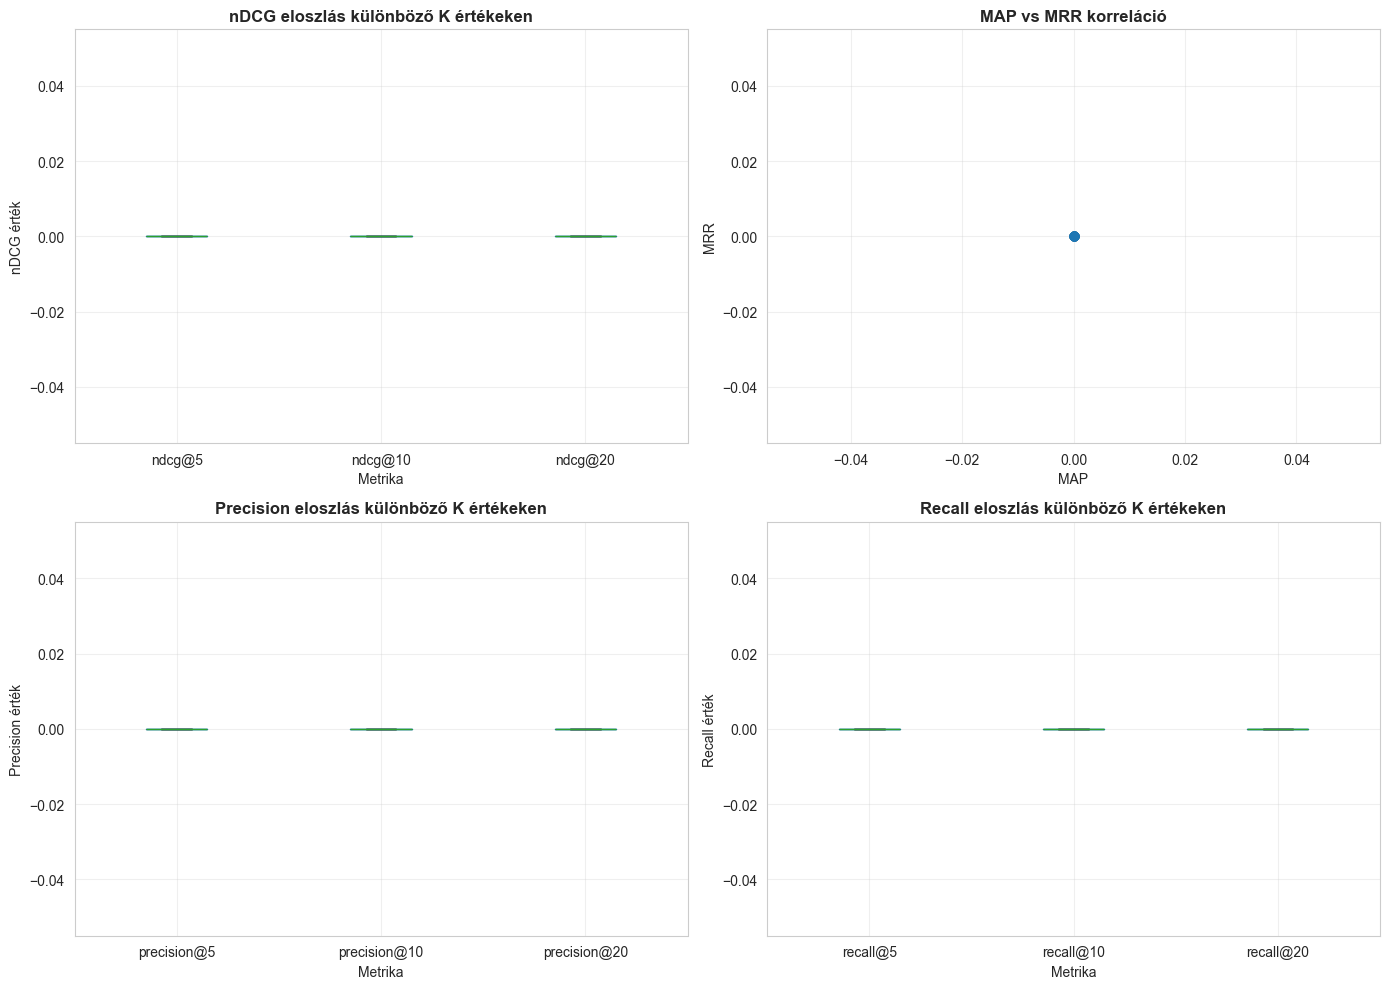

✅ Vizualizációk generálva


In [9]:
if not query_metrics_df.empty:
    # Stílus beállítása
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (14, 10)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. nDCG@K eloszlás
    ax1 = axes[0, 0]
    ndcg_cols = [col for col in query_metrics_df.columns if col.startswith('ndcg@')]
    query_metrics_df[ndcg_cols].boxplot(ax=ax1)
    ax1.set_title('nDCG eloszlás különböző K értékeken', fontsize=12, fontweight='bold')
    ax1.set_ylabel('nDCG érték')
    ax1.set_xlabel('Metrika')
    ax1.grid(True, alpha=0.3)
    
    # 2. MAP vs MRR
    ax2 = axes[0, 1]
    ax2.scatter(query_metrics_df['map'], query_metrics_df['mrr'], alpha=0.6)
    ax2.set_title('MAP vs MRR korreláció', fontsize=12, fontweight='bold')
    ax2.set_xlabel('MAP')
    ax2.set_ylabel('MRR')
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision@K eloszlás
    ax3 = axes[1, 0]
    prec_cols = [col for col in query_metrics_df.columns if col.startswith('precision@')]
    query_metrics_df[prec_cols].boxplot(ax=ax3)
    ax3.set_title('Precision eloszlás különböző K értékeken', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Precision érték')
    ax3.set_xlabel('Metrika')
    ax3.grid(True, alpha=0.3)
    
    # 4. Recall@K eloszlás
    ax4 = axes[1, 1]
    recall_cols = [col for col in query_metrics_df.columns if col.startswith('recall@')]
    query_metrics_df[recall_cols].boxplot(ax=ax4)
    ax4.set_title('Recall eloszlás különböző K értékeken', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Recall érték')
    ax4.set_xlabel('Metrika')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Vizualizációk generálva")


## 9. nDCG@10 Részletes Eloszlás


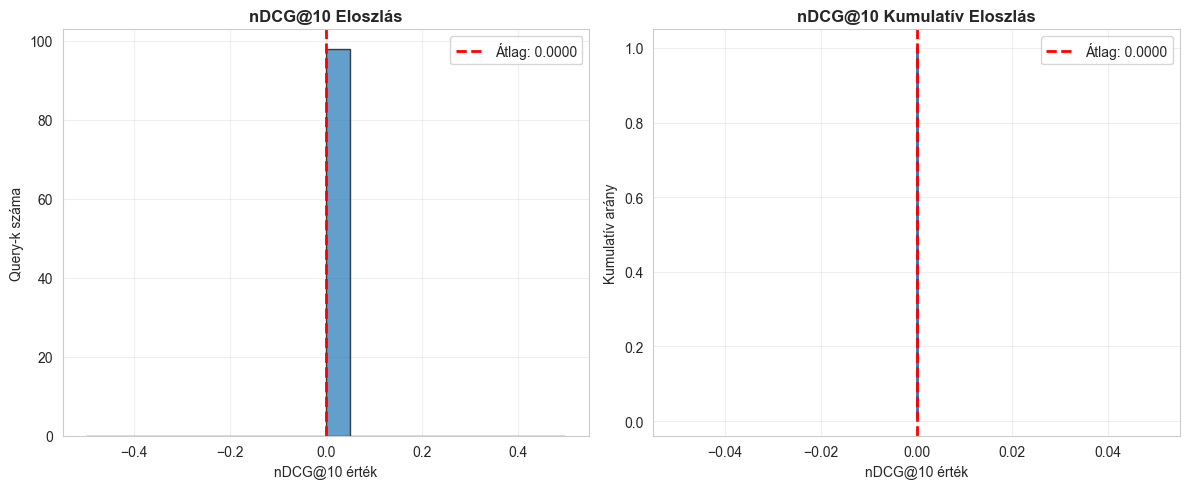


📊 nDCG@10 Percentilisek:
  • 10. percentilis: 0.0000
  • 25. percentilis: 0.0000
  • 50. percentilis: 0.0000
  • 75. percentilis: 0.0000
  • 90. percentilis: 0.0000


In [10]:
if not query_metrics_df.empty and 'ndcg@10' in query_metrics_df.columns:
    plt.figure(figsize=(12, 5))
    
    # Hisztogram
    plt.subplot(1, 2, 1)
    plt.hist(query_metrics_df['ndcg@10'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(aggregated_metrics['ndcg@10'], color='red', linestyle='--', linewidth=2, label=f'Átlag: {aggregated_metrics["ndcg@10"]:.4f}')
    plt.title('nDCG@10 Eloszlás', fontsize=12, fontweight='bold')
    plt.xlabel('nDCG@10 érték')
    plt.ylabel('Query-k száma')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Kumulatív eloszlás
    plt.subplot(1, 2, 2)
    sorted_ndcg = np.sort(query_metrics_df['ndcg@10'])
    cumulative = np.arange(1, len(sorted_ndcg) + 1) / len(sorted_ndcg)
    plt.plot(sorted_ndcg, cumulative, linewidth=2)
    plt.axvline(aggregated_metrics['ndcg@10'], color='red', linestyle='--', linewidth=2, label=f'Átlag: {aggregated_metrics["ndcg@10"]:.4f}')
    plt.title('nDCG@10 Kumulatív Eloszlás', fontsize=12, fontweight='bold')
    plt.xlabel('nDCG@10 érték')
    plt.ylabel('Kumulatív arány')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Percentilisek
    percentiles = [10, 25, 50, 75, 90]
    print("\n📊 nDCG@10 Percentilisek:")
    for p in percentiles:
        value = np.percentile(query_metrics_df['ndcg@10'], p)
        print(f"  • {p}. percentilis: {value:.4f}")


## 10. Eredmények Mentése


In [11]:
# Mentési útvonalak
output_dir = project_root / "data" / "models" / "grpo_policy"
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Aggregált metrikák JSON-ba
if aggregated_metrics:
    baseline_metrics_path = output_dir / "baseline_metrics.json"
    with open(baseline_metrics_path, 'w', encoding='utf-8') as f:
        json.dump(aggregated_metrics, f, indent=2, ensure_ascii=False)
    print(f"✅ Aggregált metrikák mentve: {baseline_metrics_path}")

# 2. Query-szintű eredmények CSV-be
if not query_metrics_df.empty:
    query_metrics_path = output_dir / "baseline_query_metrics.csv"
    query_metrics_df.to_csv(query_metrics_path, index=False, encoding='utf-8')
    print(f"✅ Query-szintű metrikák mentve: {query_metrics_path}")

# 3. Baseline találati listák JSONL-be (GRPO training inputhoz)
if baseline_results:
    baseline_results_path = output_dir / "baseline_results.jsonl"
    with open(baseline_results_path, 'w', encoding='utf-8') as f:
        for query_id, doc_ids in baseline_results.items():
            result_obj = {
                "query_id": query_id,
                "doc_ids": doc_ids,
                "num_results": len(doc_ids)
            }
            f.write(json.dumps(result_obj, ensure_ascii=False) + '\n')
    print(f"✅ Baseline találati listák mentve: {baseline_results_path}")

print("\n🎉 Minden eredmény sikeresen mentve!")


✅ Aggregált metrikák mentve: /Users/zelenyianszkimate/Documents/CourtRankRL/data/models/grpo_policy/baseline_metrics.json
✅ Query-szintű metrikák mentve: /Users/zelenyianszkimate/Documents/CourtRankRL/data/models/grpo_policy/baseline_query_metrics.csv
✅ Baseline találati listák mentve: /Users/zelenyianszkimate/Documents/CourtRankRL/data/models/grpo_policy/baseline_results.jsonl

🎉 Minden eredmény sikeresen mentve!


## 11. Összefoglalás és Következő Lépések


In [12]:
print("\n" + "="*60)
print("📝 ÖSSZEFOGLALÁS")
print("="*60)

if aggregated_metrics:
    print(f"\n✅ Baseline értékelés sikeres:")
    print(f"   • nDCG@10: {aggregated_metrics.get('ndcg@10', 0.0):.4f}")
    print(f"   • MAP:     {aggregated_metrics.get('map', 0.0):.4f}")
    print(f"   • MRR:     {aggregated_metrics.get('mrr', 0.0):.4f}")
    
    print(f"\n📊 Cél a GRPO reranking után:")
    target_ndcg = aggregated_metrics.get('ndcg@10', 0.0) + 0.03
    print(f"   • Elvárt nDCG@10 javulás: ≥0.03")
    print(f"   • Célérték: ≥{target_ndcg:.4f}")
    print(f"   • Javulást elérő query-k aránya: ≥60%")
    
    print(f"\n🚀 Következő lépések:")
    print(f"   1. GRPO training notebook (grpo_train_runpod.ipynb) futtatása")
    print(f"   2. LoRA adapter training cloud környezetben")
    print(f"   3. Reranked eredmények kiértékelése")
    print(f"   4. Baseline vs. GRPO összehasonlítás")
else:
    print("\n⚠️  Nincs elérhető baseline eredmény")
    print("   Ellenőrizd a qrels fájlt és a hybrid_search komponenseket")

print("\n" + "="*60)



📝 ÖSSZEFOGLALÁS

✅ Baseline értékelés sikeres:
   • nDCG@10: 0.0000
   • MAP:     0.0000
   • MRR:     0.0000

📊 Cél a GRPO reranking után:
   • Elvárt nDCG@10 javulás: ≥0.03
   • Célérték: ≥0.0300
   • Javulást elérő query-k aránya: ≥60%

🚀 Következő lépések:
   1. GRPO training notebook (grpo_train_runpod.ipynb) futtatása
   2. LoRA adapter training cloud környezetben
   3. Reranked eredmények kiértékelése
   4. Baseline vs. GRPO összehasonlítás

